In [1]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

from copy import deepcopy
from sklearn.base import clone
from sklearn.preprocessing import OrdinalEncoder

from sklearn.naive_bayes import BernoulliNB, MultinomialNB, CategoricalNB
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay)

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1


In [2]:
from preprocess_classes import (
    DFDropColumns, DFWoeEncoder, DFColumnBinning, DFValuesMapper, DFFuncApplyCols,
    DFCrossFeaturesImputer, DFOneHotEncoder, DFOrdinalEncoder, DFValuesReplacer
)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
option_no = 8
dataset_type = 'train'
filename_template = 'datasets/processed/bank-{}-encoded-opt{}.csv'

In [5]:
df_train = pd.read_csv(filename_template.format(dataset_type, option_no), comment='#')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  float64
 2   marital         28831 non-null  float64
 3   education       28831 non-null  float64
 4   default         28831 non-null  int64  
 5   housing         28831 non-null  int64  
 6   loan            28831 non-null  int64  
 7   contact         28831 non-null  int64  
 8   month           28831 non-null  int64  
 9   day_of_week     28831 non-null  int64  
 10  campaign        28831 non-null  int64  
 11  pdays           28831 non-null  int64  
 12  previous        28831 non-null  int64  
 13  poutcome        28831 non-null  int64  
 14  emp.var.rate    28831 non-null  float64
 15  cons.price.idx  28831 non-null  float64
 16  cons.conf.idx   28831 non-null  float64
 17  euribor3m       28831 non-null 

NaiveBayes models are sensitive to negative values

In [6]:
(df_train < 0).sum()

age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
campaign              0
pdays             27734
previous              0
poutcome           3003
emp.var.rate      12035
cons.price.idx        0
cons.conf.idx     28831
euribor3m             0
nr.employed           0
y                     0
dtype: int64

In [7]:
df_train['pdays'] = df_train['pdays'].replace(-1, 999)
df_train['pdays'].value_counts()

999    27734
3        317
6        300
13        94
4         86
2         49
7         42
10        40
9         39
12        34
5         33
11        20
1         19
0         12
8         12
Name: pdays, dtype: int64

In [8]:
df_train['poutcome'].value_counts()

 0    24838
-1     3003
 1      990
Name: poutcome, dtype: int64

In [9]:
df_train['poutcome'] = df_train['poutcome'] + 1
df_train['poutcome'].value_counts()

1    24838
0     3003
2      990
Name: poutcome, dtype: int64

In [10]:
df_train['emp.var.rate'].value_counts()

 1.4    11396
-1.8     6439
 1.1     5400
-0.1     2564
-2.9     1151
-3.4      744
-1.7      553
-1.1      458
-3.0      121
-0.2        5
Name: emp.var.rate, dtype: int64

In [11]:
df_train['emp.var.rate'] = df_train['emp.var.rate'] + 100
df_train['emp.var.rate']

0        101.1
1        101.1
2         98.2
3        101.4
4         98.2
         ...  
28826     98.2
28827    101.1
28828    101.4
28829     98.2
28830    101.4
Name: emp.var.rate, Length: 28831, dtype: float64

In [12]:
df_train['cons.conf.idx'].value_counts()

-36.4    5400
-42.7    4675
-46.2    4087
-36.1    3666
-41.8    3055
-42.0    2519
-47.1    1701
-31.4     529
-40.8     494
-26.9     316
-30.1     243
-40.3     230
-37.5     221
-50.0     192
-29.8     185
-34.8     179
-38.3     170
-40.0     159
-39.8     153
-49.5     152
-33.6     128
-33.0     121
-34.6     121
-50.8      85
-40.4      45
-45.9       5
Name: cons.conf.idx, dtype: int64

In [13]:
df_train['cons.conf.idx'] = df_train['cons.conf.idx'] + 100
df_train['cons.conf.idx'].value_counts()

63.6    5400
57.3    4675
53.8    4087
63.9    3666
58.2    3055
58.0    2519
52.9    1701
68.6     529
59.2     494
73.1     316
69.9     243
59.7     230
62.5     221
50.0     192
70.2     185
65.2     179
61.7     170
60.0     159
60.2     153
50.5     152
66.4     128
67.0     121
65.4     121
49.2      85
59.6      45
54.1       5
Name: cons.conf.idx, dtype: int64

In [14]:
X_train_full, y_train_full = df_train.drop(columns=['y']), df_train['y']
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=['y']), df_train['y'], test_size=0.2, stratify=df_train['y'], random_state=6868687)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1024503) #random_state=7868686

In [15]:
def get_model_results(model, train_set, test_set=None, show_charts=False):
    metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 'auc': roc_auc_score}
    if show_charts:
        if test_set is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[2])
            axs[0].set_title('TRAIN set: confusion matrix')
            axs[1].set_title('TRAIN set: ROC curve')
            axs[2].set_title('TRAIN set: precision-recall curve')
        else:
            fig, axs = plt.subplots(2, 3, figsize=(15, 10))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 2])
            conf_matrix_test = ConfusionMatrixDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 0])
            roc_curve_test = RocCurveDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 1])
            pr_curve_test = PrecisionRecallDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 2])
            axs[0, 0].set_title('TRAIN set: confusion matrix')
            axs[0, 1].set_title('TRAIN set: ROC curve')
            axs[0, 2].set_title('TRAIN set: precision-recall curve')
            axs[1, 0].set_title('TEST set: confusion matrix')
            axs[1, 1].set_title('TEST set: ROC curve')
            axs[1, 2].set_title('TEST set: precision-recall curve')
    
    results = {}
    print('Scores:')
    print('Indicator  \tTrain \tTest')
    print('='*40)
    for m_name, m_func in metrics.items():
        results[m_name] = {} 
        results[m_name]['train'] = m_func(train_set[1], model.predict(train_set[0]))
        if test_set is not None:
            results[m_name]['test'] = m_func(test_set[1], model.predict(test_set[0]))
        print('{}:     \t{:.4f} \t{:.4f}'.format(m_name, results[m_name]['train'], 0.0 if test_set is None else results[m_name]['test']))
    
    return results

## Testing MultinomialNB

In [16]:
param_grid = {'alpha': [0, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0], 'fit_prior': [True, False]}

In [17]:
gridcv = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=kfold, scoring='recall', return_train_score=True)
gridcv.fit(X_train_full, y_train_full)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1024503, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': [0, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
                         'fit_prior': [True, False]},
             return_train_score=True, scoring='recall')

Scores:
Indicator  	Train 	Test
accuracy:     	0.8971 	0.8977
precision:     	0.6283 	0.6364
recall:     	0.2121 	0.2154
f1:     	0.3171 	0.3218
auc:     	0.5981 	0.5999


{'accuracy': {'train': 0.8971123829344433, 'test': 0.8976937749263049},
 'precision': {'train': 0.6282782212086659, 'test': 0.6363636363636364},
 'recall': {'train': 0.21208622016936104, 'test': 0.2153846153846154},
 'f1': {'train': 0.3171223021582734, 'test': 0.3218390804597701},
 'auc': {'train': 0.5980786812759246, 'test': 0.5998752273718074}}

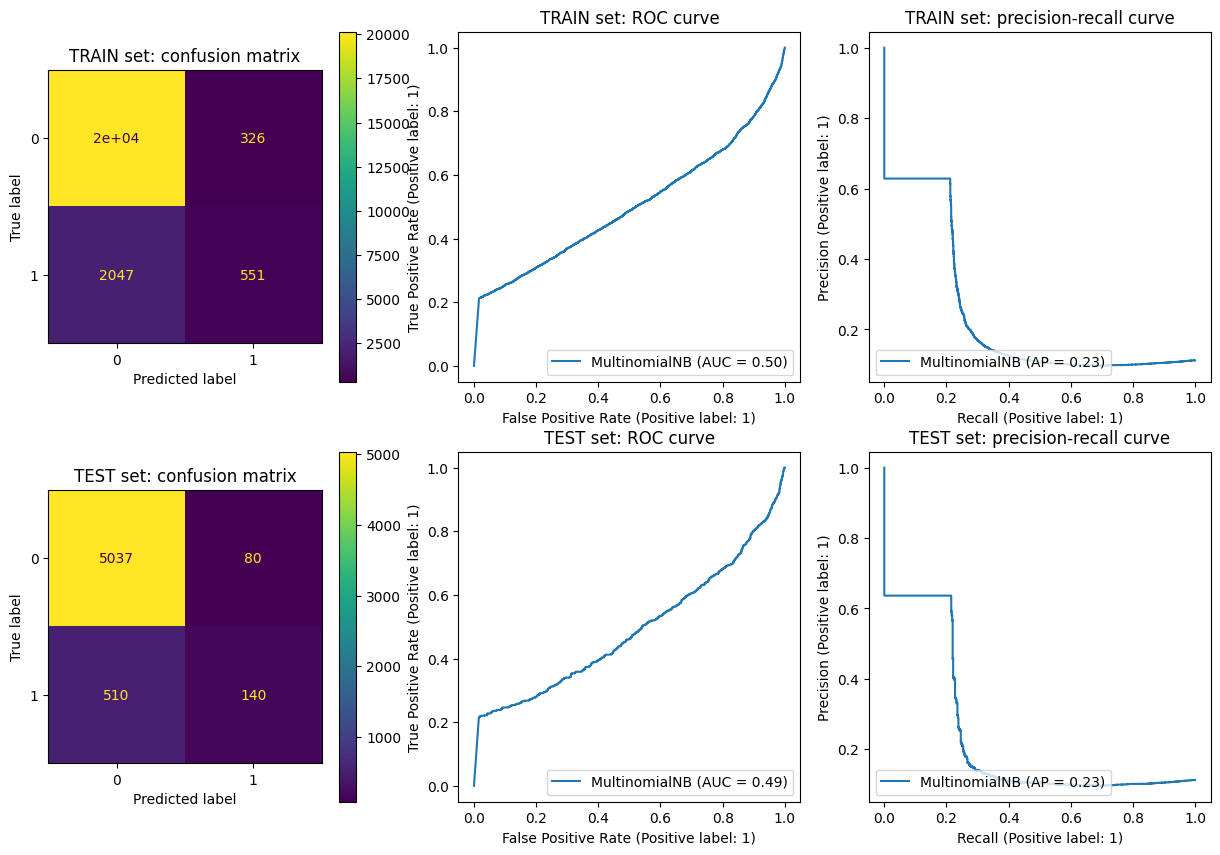

In [18]:
get_model_results(gridcv.best_estimator_, train_set=(X_train, y_train), test_set=(X_val, y_val), show_charts=True)

In [19]:
gridcv.best_estimator_.get_params()

{'alpha': 0, 'class_prior': None, 'fit_prior': True}

MultinomialNB in this task appears to be like or slightly worse than random guess

## Testing CategoricalNB

### Single model with default params

In [20]:
cv_res = cross_validate(CategoricalNB(), X_train_full, y_train_full, scoring='recall', cv=kfold, n_jobs=3, return_train_score=True, return_estimator=True)
#catbayes_clf = cv_res['estimator'][cv]
cv_res

{'fit_time': array([0.04000115, 0.041991  , 0.03899217, 0.0369947 , 0.03600097]),
 'score_time': array([0.07699323, 0.00699854, 0.00699854, 0.00900149, 0.00901365]),
 'estimator': [CategoricalNB(),
  CategoricalNB(),
  CategoricalNB(),
  CategoricalNB(),
  CategoricalNB()],
 'test_score': array([       nan, 0.53466872, 0.50539291, 0.53846154, 0.54      ]),
 'train_score': array([0.53156274, 0.53366679, 0.54405541, 0.53387221, 0.53271747])}

In [21]:
catbayes_clf = cv_res['estimator'][np.where(np.isnan(cv_res['test_score']), 0, cv_res['test_score']).argmax()]
catbayes_clf

CategoricalNB()

Scores:
Indicator  	Train 	Test
accuracy:     	0.8688 	0.8646
precision:     	0.4335 	0.4190
recall:     	0.5373 	0.5215
f1:     	0.4799 	0.4647
auc:     	0.7241 	0.7148


{'accuracy': {'train': 0.8687998612556365, 'test': 0.8645743020634645},
 'precision': {'train': 0.4335403726708075, 'test': 0.41903584672435107},
 'recall': {'train': 0.5373364126250962, 'test': 0.5215384615384615},
 'f1': {'train': 0.47988999656239256, 'test': 0.4647018505825908},
 'auc': {'train': 0.7241064942046619, 'test': 0.7148438838862916}}

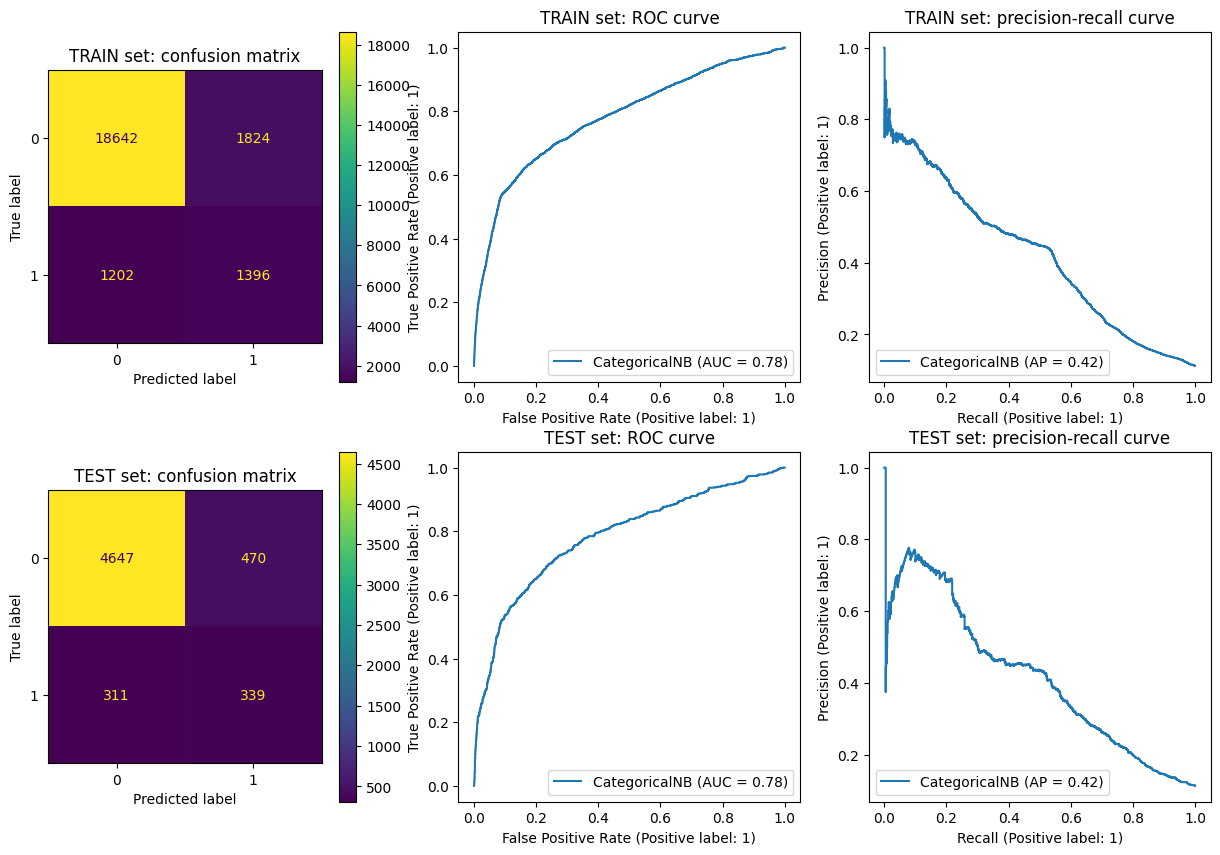

In [22]:
get_model_results(catbayes_clf, train_set=(X_train, y_train), test_set=(X_val, y_val), show_charts=True)

### Grid Search with CategoricalNB

In [23]:
gridcv = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=kfold, scoring='recall', return_train_score=True)
gridcv.fit(X_train_full, y_train_full)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1024503, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': [0, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
                         'fit_prior': [True, False]},
             return_train_score=True, scoring='recall')

In [24]:
gridcv.best_estimator_.get_params()

{'alpha': 0, 'class_prior': None, 'fit_prior': True}

Scores:
Indicator  	Train 	Test
accuracy:     	0.8971 	0.8977
precision:     	0.6283 	0.6364
recall:     	0.2121 	0.2154
f1:     	0.3171 	0.3218
auc:     	0.5981 	0.5999


{'accuracy': {'train': 0.8971123829344433, 'test': 0.8976937749263049},
 'precision': {'train': 0.6282782212086659, 'test': 0.6363636363636364},
 'recall': {'train': 0.21208622016936104, 'test': 0.2153846153846154},
 'f1': {'train': 0.3171223021582734, 'test': 0.3218390804597701},
 'auc': {'train': 0.5980786812759246, 'test': 0.5998752273718074}}

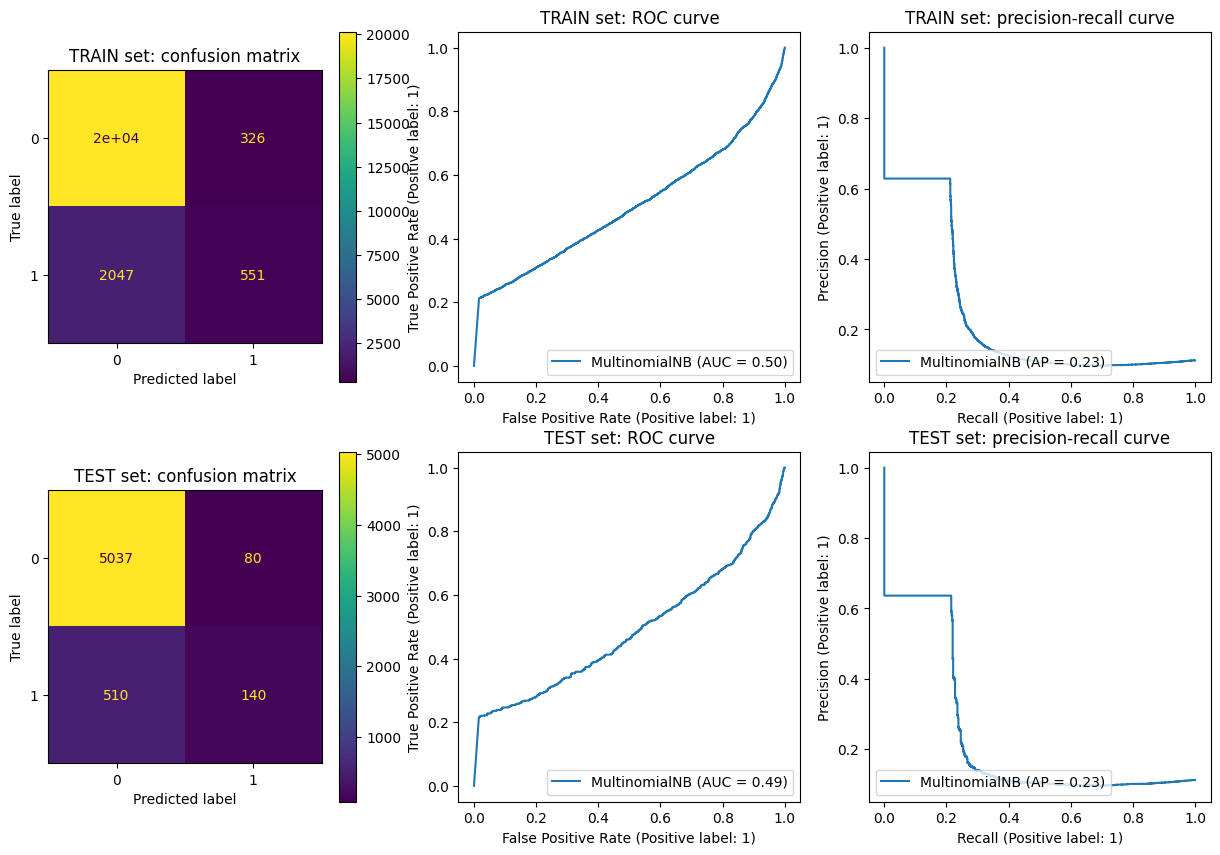

In [25]:
get_model_results(gridcv.best_estimator_, train_set=(X_train, y_train), test_set=(X_val, y_val), show_charts=True)

### Testing CategoricalNB with clustering

In [26]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1024503)
n_components = 2
datasets_options = [option_no]
pps = [50]
subplot_size = (7, 7) # (width, height)

In [27]:
df = pd.read_csv(f'datasets/processed/bank-train-encoded-opt{option_no}.csv', comment='#')
_, idxs = list(kfold.split(df.drop(columns=['y']), df['y']))[0]

tsne = TSNE(n_components=n_components, perplexity=pps[0], random_state=1028503, init='pca', learning_rate='auto', n_jobs=3)
tsne_res = tsne.fit_transform(df.drop(columns=['y']).iloc[idxs])
df_tsne = pd.DataFrame(tsne_res, index=idxs, columns=['tsne_x', 'tsne_y'])

In [28]:
df_tsne[df_tsne['tsne_x']<-90].index

Int64Index([   46,    69,    87,   118,   168,   171,   189,   277,   279,
              310,
            ...
            28449, 28453, 28481, 28531, 28604, 28680, 28714, 28726, 28741,
            28748],
           dtype='int64', length=733)

{1: {'idxs': Int64Index([   46,    69,    87,   118,   168,   171,   189,   277,   279,
              310,
            ...
            28449, 28453, 28481, 28531, 28604, 28680, 28714, 28726, 28741,
            28748],
           dtype='int64', length=733), 'proba': 0.05593451568894952}, 2: {'idxs': Int64Index([    7,     8,     9,    37,    43,    77,    82,    84,    88,
              108,
            ...
            28749, 28758, 28759, 28788, 28794, 28797, 28802, 28804, 28813,
            28814],
           dtype='int64', length=3134), 'proba': 0.05073388640714742}, 3: {'idxs': Int64Index([    5,    19,    24,    35,    63,    78,    94,   132,   222,
              229,
            ...
            28575, 28579, 28593, 28629, 28655, 28718, 28778, 28800, 28823,
            28826],
           dtype='int64', length=1200), 'proba': 0.11}, 4: {'idxs': Int64Index([  328,   544,   622,   673,  1050,  1076,  1374,  1388,  1427,
             1438,
            ...
            27911, 28070, 281

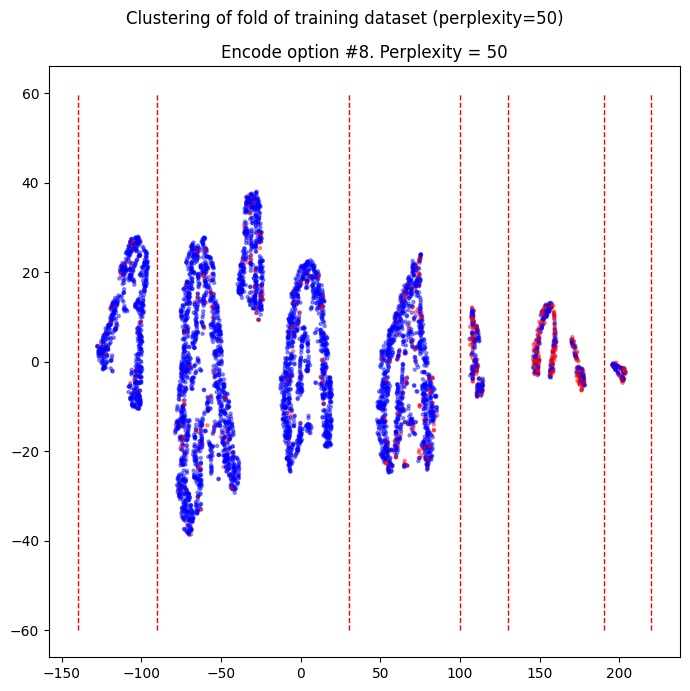

In [29]:
delimiters = [
    {'x': [-140, -140], 'y': [-60, 60]},
    {'x': [-90, -90], 'y': [-60, 60]},
    #{'x': [-45, -45], 'y': [-60, 60]},
    #{'x': [-20, -20], 'y': [-60, 60]},
    {'x': [30, 30], 'y': [-60, 60]},
    {'x': [100, 100], 'y': [-60, 60]},
    {'x': [130, 130], 'y': [-60, 60]},
    #{'x': [165, 165], 'y': [-60, 60]},
    {'x': [190, 190], 'y': [-60, 60]},
    {'x': [220, 220], 'y': [-60, 60]},
]
cluster_proba = {}
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
axs.scatter(tsne_res[:, 0], tsne_res[:, 1], c=df['y'].iloc[idxs], s=5, cmap='bwr', alpha=0.4)
axs.set_title(f'Encode option #{option_no}. Perplexity = {pps[0]}')
for i, delim_coord in enumerate(delimiters):
    axs.plot(delim_coord['x'], delim_coord['y'], 'r--', lw=1)
    if i > 0:
        cluster_proba[i] = {}
        x_min, x_max = delimiters[i-1]['x'][0], delimiters[i]['x'][0]
        cluster_idxs = df_tsne[(df_tsne['tsne_x'] > x_min) & (df_tsne['tsne_x'] < x_max)].index
        cluster_proba[i]['idxs'] = cluster_idxs
        cluster_proba[i]['proba'] = df.iloc[cluster_idxs]['y'].mean()
fig.suptitle(f'Clustering of fold of training dataset (perplexity={pps[0]})')
fig.tight_layout();
print(cluster_proba)

In [30]:
# try to create 3 clusters (low / moderate / high probability of positive outcome)
# take first index from leftmost, middle and rightmost clusters as initialization values for knn
knn_cluster_init_idxs = [
    cluster_proba[1]['idxs'][0], # leftmost (low probability ~5%) cluster
    cluster_proba[3]['idxs'][0], # middle (moderate probability ~11%) cluster
    cluster_proba[6]['idxs'][0], # rightmost (high probability ~50%) cluster
]
clusterizer = KMeans(3, init=[df.drop(columns=['y']).iloc[i] for i in knn_cluster_init_idxs])
clusterizer.fit(df.drop(columns=['y']))

KMeans(init=[age                 49.000
job                  0.000
marital              0.000
education            5.000
default              0.000
housing              1.000
loan                 1.000
contact              1.000
month                8.000
day_of_week          1.000
campaign             1.000
pdays               -1.000
previous             0.000
poutcome             0.000
emp.var.rate         1.400
cons.price.idx      93.444
cons.conf.idx      -36.100
euribor3m            4.970
nr.employed       5228.100
Name: 46, dtype: float64,
             age                 52.000
job                  9.000
marital              1.000
education            1.000
default              0.000
housin...
cons.conf.idx      -46.200
euribor3m            1.266
nr.employed       5099.100
Name: 5, dtype: float64,
             age                 70.000
job                  5.000
marital              0.000
education            5.000
default              0.000
housing              1.000
loan                 0.000
contact              0.000
month                9.000
day_of_week          3.000
campaign             4.000
pdays               -1.000
previous             0.000
poutcome             0.000
emp.var.rate        -1.100
cons.price.idx      94.199
cons.conf.idx      -37.500
euribor3m            0.886
nr.employed       4963.600
Name: 445, dtype: float64],
       n_clusters=3)

In [31]:
df['cluster'] = clusterizer.predict(df.drop(columns=['y']))
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cluster
0,50,1.0,2.0,0.0,0,0,0,0,5,4,...,-1,0,0,1.1,93.994,-36.4,4.860,5191.0,0,0
1,51,7.0,1.0,5.0,0,0,0,0,5,1,...,-1,0,0,1.1,93.994,-36.4,4.858,5191.0,0,0
2,46,9.0,0.0,5.0,0,1,0,1,5,1,...,-1,0,0,-1.8,92.893,-46.2,1.244,5099.1,0,1
3,46,0.0,2.0,6.0,0,1,0,0,6,1,...,-1,0,0,1.4,94.465,-41.8,4.961,5228.1,0,0
4,25,7.0,2.0,3.0,0,0,0,1,5,4,...,-1,0,0,-1.8,92.893,-46.2,1.266,5099.1,1,1
5,52,9.0,1.0,1.0,0,0,0,1,5,4,...,-1,1,-1,-1.8,92.893,-46.2,1.266,5099.1,0,1
6,29,9.0,2.0,6.0,0,1,0,1,6,3,...,-1,0,0,-2.9,92.963,-40.8,1.260,5076.2,0,1
7,42,9.0,1.0,5.0,0,0,0,1,7,1,...,-1,0,0,1.4,93.918,-42.7,4.960,5228.1,0,0
8,52,0.0,1.0,0.0,0,1,1,1,11,1,...,-1,0,0,-0.1,93.200,-42.0,4.191,5195.8,0,0
9,47,3.0,1.0,0.0,0,1,0,1,11,3,...,-1,0,0,-0.1,93.200,-42.0,4.120,5195.8,0,0


In [32]:
df.groupby(['cluster'])['y'].mean()

cluster
0    0.049832
1    0.160987
2    0.486081
Name: y, dtype: float64

In [33]:
nb_clfs = {}
for i in range(3):
    idxs = df[df['cluster'] == i].index
    cv_res = cross_validate(CategoricalNB(), X_train_full.loc[idxs], y_train_full[idxs], scoring='recall', cv=kfold, n_jobs=3, return_train_score=True, return_estimator=True)
    nb_clfs[i] = cv_res['estimator'][np.where(np.isnan(cv_res['test_score']), 0, cv_res['test_score']).argmax()]
nb_clfs

{0: CategoricalNB(), 1: CategoricalNB(), 2: CategoricalNB()}

Scores:
Indicator  	Train 	Test
accuracy:     	0.9505 	0.0000
precision:     	0.5577 	0.0000
recall:     	0.0301 	0.0000
f1:     	0.0570 	0.0000
auc:     	0.5144 	0.0000
Scores:
Indicator  	Train 	Test
accuracy:     	0.8004 	0.0000
precision:     	0.3684 	0.0000
recall:     	0.3354 	0.0000
f1:     	0.3511 	0.0000
auc:     	0.6125 	0.0000
Scores:
Indicator  	Train 	Test
accuracy:     	0.6694 	0.0000
precision:     	0.6913 	0.0000
recall:     	0.5780 	0.0000
f1:     	0.6296 	0.0000
auc:     	0.6669 	0.0000


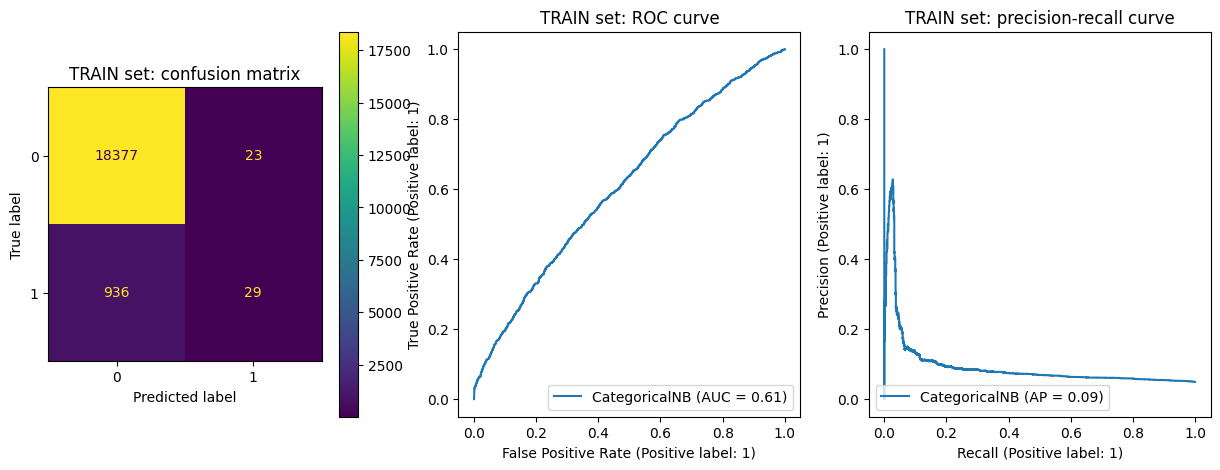

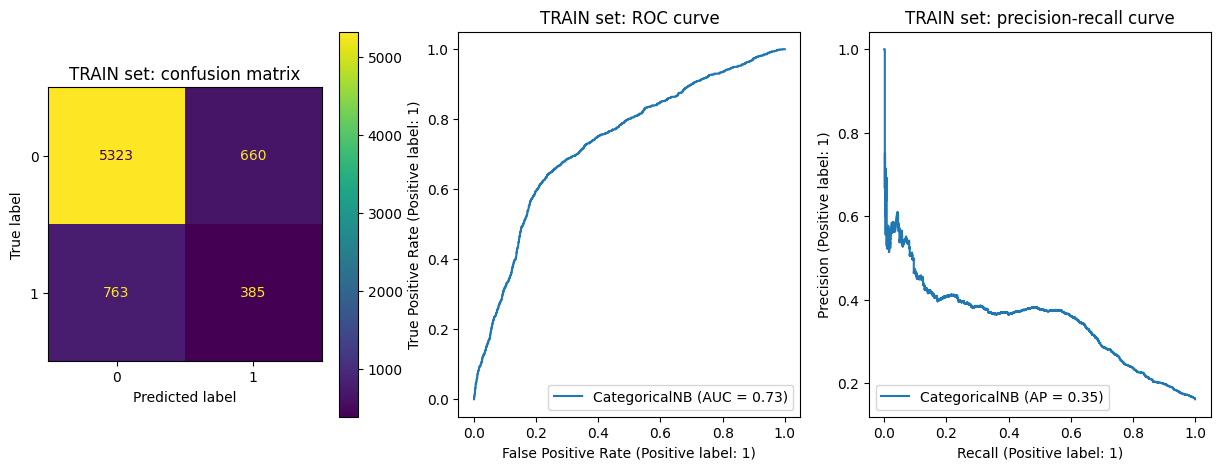

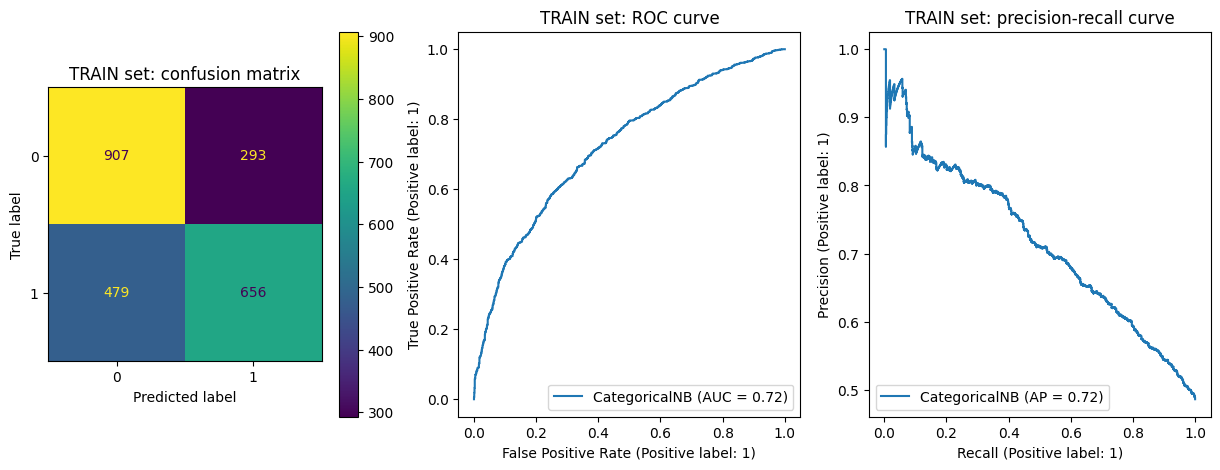

In [34]:
for i in range(3):
    idxs = df[df['cluster'] == i].index
    get_model_results(nb_clfs[i], train_set=(X_train_full.loc[idxs], y_train_full[idxs]), test_set=None, show_charts=True)

## Testing BernoulliNB (on binary encoded dataset)

In [35]:
# SPECIAL PREPROCESSING dataset for BernoulliNB: one-hot encoding
df_bernoully = pd.read_csv('datasets/bank-train.csv')
df_bernoully.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp.var.rate    28831 non-null  float64
 16  cons.price.idx  28831 non-null  float64
 17  cons.conf.idx   28831 non-null 

In [36]:
df_bernoully.head(8)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
4,25,services,single,high.school,no,no,no,cellular,may,thu,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes
5,52,technician,married,basic.6y,unknown,no,no,cellular,may,thu,...,3,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
6,29,technician,single,university.degree,no,yes,no,cellular,jun,wed,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2,no
7,42,technician,married,professional.course,unknown,no,no,cellular,jul,mon,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no


In [37]:
# definition of inputs for binning and encoding
age_bins = pd.IntervalIndex.from_breaks(np.arange(15, 110, 10))
pdays_bins = pd.IntervalIndex.from_breaks([-1, 3, 6, 13, 50, 999], closed='right')
y_map = {'yes': 1, 'no': 0}
default_map = {'yes': 1, 'no': 0, 'unknown': 0}
housing_map = {'yes': 1, 'no': 0, 'unknown': 1}
loan_map = {'yes': 1, 'no': 0, 'unknown': 0}
contact_map = {'cellular': 1, 'telephone': 0}
month_map = {'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
dow_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
poutcome_map = {'nonexistent': 0, 'success': 1, 'failure': -1}

# cutoff functions
cutoff_campaign = (lambda x: np.min([x, 6])) # value 6 was calculated in 2_eda for `campaign` feature as cutoff value
cutoff_previous = (lambda x: np.min([x, 3])) # value 3 was calculated in 2_eda for `previous` feature as cutoff value
cutoff_pdays = (lambda x: np.min([13, x])) # value 13 was calculated in 2_eda for `pdays` feature as cutoff value
binarize_pdays = (lambda x: int(x < 999)) # transforming to answer on question: was there a previous contact?

In [38]:
binarizing_pipeline = Pipeline([
    ('age_binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
    ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv='unknown')),
    ('replace_values', DFValuesReplacer(replaces={'default': {'unknown': 'no'}, 'housing': {'unknown': 'yes'}, 'loan': {'unknown': 'no'}, 'pdays': {999: -1}})),
    ('one-hot', DFOneHotEncoder(
        cols_cats={'education': 'auto', 'job': 'auto', 'marital': 'auto'},
        return_full_df=True,
        drop_originals=True,
    )),
    ('map_values', DFValuesMapper(
        map_values={
            'contact': contact_map,
            'default': default_map,
            'housing': housing_map,
            'loan': loan_map,
            'month': month_map,
            'day_of_week': dow_map,
            'poutcome': poutcome_map
        }
    )),
    # ('cat_encode', DFOrdinalEncoder( #col_cats={'column_name': 'auto' | list of array-like}
    #     cols_cats={
    #         'job': 'auto',
    #         'marital': 'auto',
    #         'education': 'auto'
    #     }
    # )),
    #('cutoff', DFFuncApplyCols(map_func={'campaign': cutoff_campaign, 'previous': cutoff_previous, 'pdays': cutoff_pdays,})),
    #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
    ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])), # , 'nr.employed', 'emp.var.rate'
    #('scale', MinMaxScaler())
])

In [39]:
y_b_train = df_bernoully['y'].map(y_map)
X_b_train = binarizing_pipeline.fit_transform(df_bernoully.drop(columns=['y']))
X_b_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            28831 non-null  int64  
 1   default                        28831 non-null  int64  
 2   housing                        28831 non-null  int64  
 3   loan                           28831 non-null  int64  
 4   contact                        28831 non-null  int64  
 5   month                          28831 non-null  int64  
 6   day_of_week                    28831 non-null  int64  
 7   campaign                       28831 non-null  int64  
 8   pdays                          28831 non-null  int64  
 9   previous                       28831 non-null  int64  
 10  poutcome                       28831 non-null  int64  
 11  emp.var.rate                   28831 non-null  float64
 12  cons.price.idx                 28831 non-null 

In [40]:
bbayes_clf = BernoulliNB(binarize=0.5)
bbayes_clf.fit(X_b_train, y_b_train)

BernoulliNB(binarize=0.5)

Scores:
Indicator  	Train 	Test
accuracy:     	0.8813 	0.0000
precision:     	0.4514 	0.0000
recall:     	0.2503 	0.0000
f1:     	0.3220 	0.0000
auc:     	0.6058 	0.0000


{'accuracy': {'train': 0.8812736290798099},
 'precision': {'train': 0.45141588006662964},
 'recall': {'train': 0.250307881773399},
 'f1': {'train': 0.3220439691027926},
 'auc': {'train': 0.6058442430404736}}

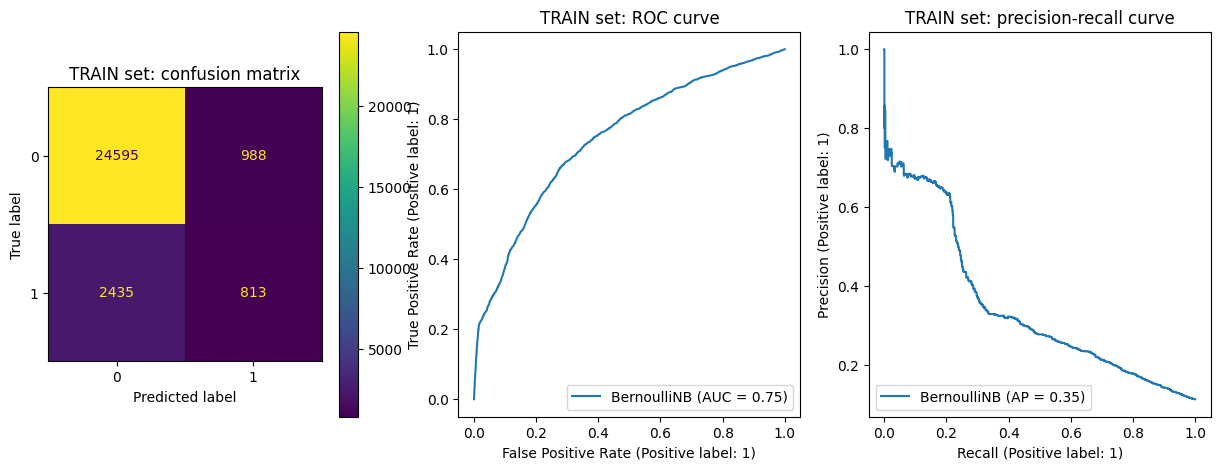

In [41]:
get_model_results(bbayes_clf, train_set=(X_b_train, y_b_train), test_set=None, show_charts=True)

In [42]:
print(classification_report(y_true=y_b_train, y_pred=bbayes_clf.predict(X_b_train)))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     25583
           1       0.45      0.25      0.32      3248

    accuracy                           0.88     28831
   macro avg       0.68      0.61      0.63     28831
weighted avg       0.86      0.88      0.87     28831



In [43]:
# visualization is computationally expensive so we have to limit number of data points
# splits have to be stratified to guarantee preserving positive / negative ratio
max_datapoints = 8000
n_splits = np.ceil(len(X_b_train) / max_datapoints)
print(f'Splitting dataset into {n_splits} folds')
kfold = StratifiedKFold(n_splits=int(n_splits), shuffle=True, random_state=1024503) #, random_state=1024503
_, idxs = list(kfold.split(X_b_train, y_b_train))[0]
print('1st fold contain {} data points'.format(len(idxs)))

Splitting dataset into 4.0 folds
1st fold contain 7208 data points


In [44]:
# settings for visualization subplots
n_components = 2
#datasets_options = [1, 4, 5, 10]
pps = [10, 50, 100]
subplot_size = (7, 7) # (width, height)

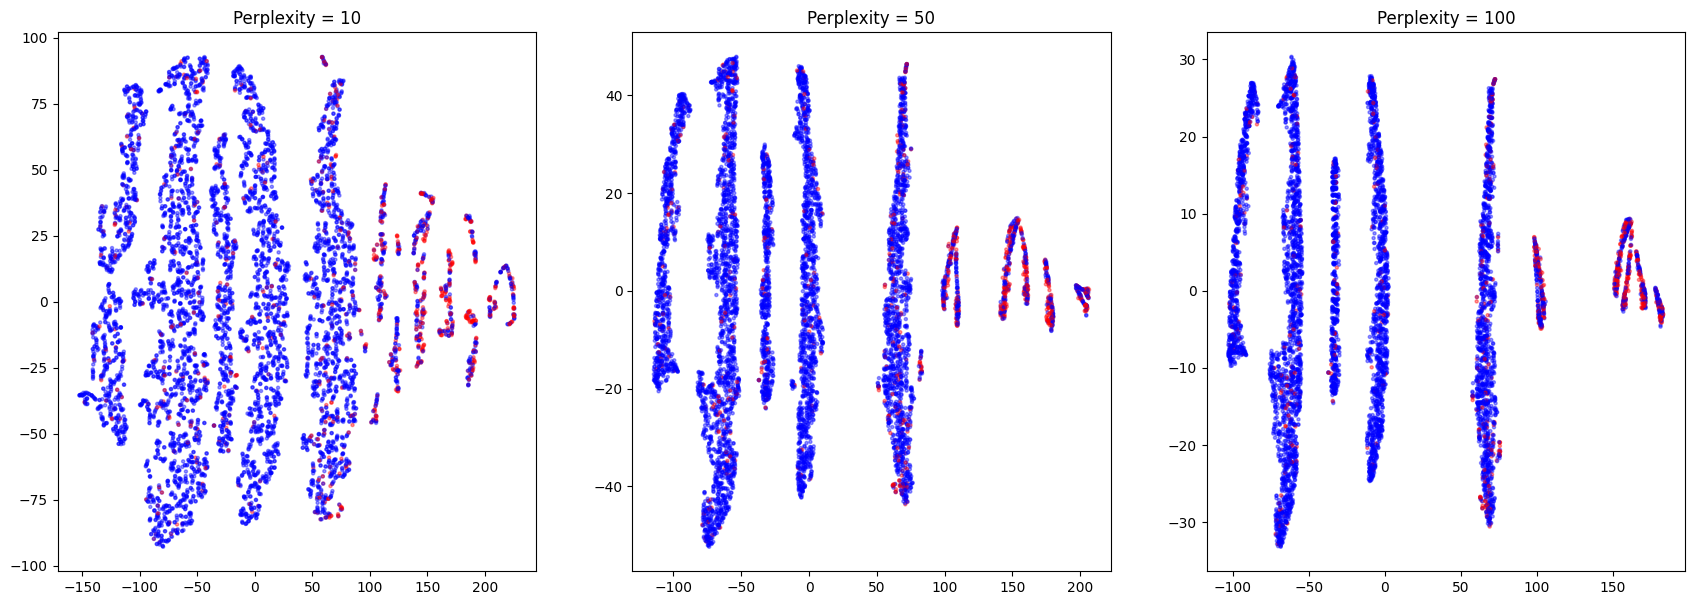

In [45]:
plots_cols = len(pps)
#plots_rows = len(datasets_options)
fig, axs = plt.subplots(1, plots_cols, figsize=(subplot_size[0]*plots_cols, subplot_size[1]))

for j, pp in enumerate(pps):
    tsne = TSNE(n_components=n_components, perplexity=pp, random_state=1028503, init='pca', learning_rate='auto', n_jobs=3) #, n_jobs=3
    tsne_res = tsne.fit_transform(X_b_train.iloc[idxs])
    axs[j].scatter(tsne_res[:, 0], tsne_res[:, 1], c=y_b_train.iloc[idxs], s=5, cmap='bwr', alpha=0.4)
    axs[j].set_title(f'Perplexity = {pp}');

In [46]:
pp = 100
dfs_tsne = []
for _, idxs in kfold.split(X_b_train, y_b_train):
    tsne = TSNE(n_components=n_components, perplexity=pp, random_state=1028503, init='pca', learning_rate='auto', n_jobs=3)
    tsne_res = tsne.fit_transform(X_b_train.iloc[idxs])
    dfs_tsne.append(pd.DataFrame(tsne_res, index=idxs, columns=['tsne_x', 'tsne_y']))

Cluster 	Observ 	Proba
Cluster 1 	927 	4.64
Cluster 2 	1860 	5.11
Cluster 3 	640 	7.03
Cluster 4 	1332 	2.78
Cluster 5 	1564 	12.98
Cluster 6 	297 	36.03
Cluster 7 	587 	48.04


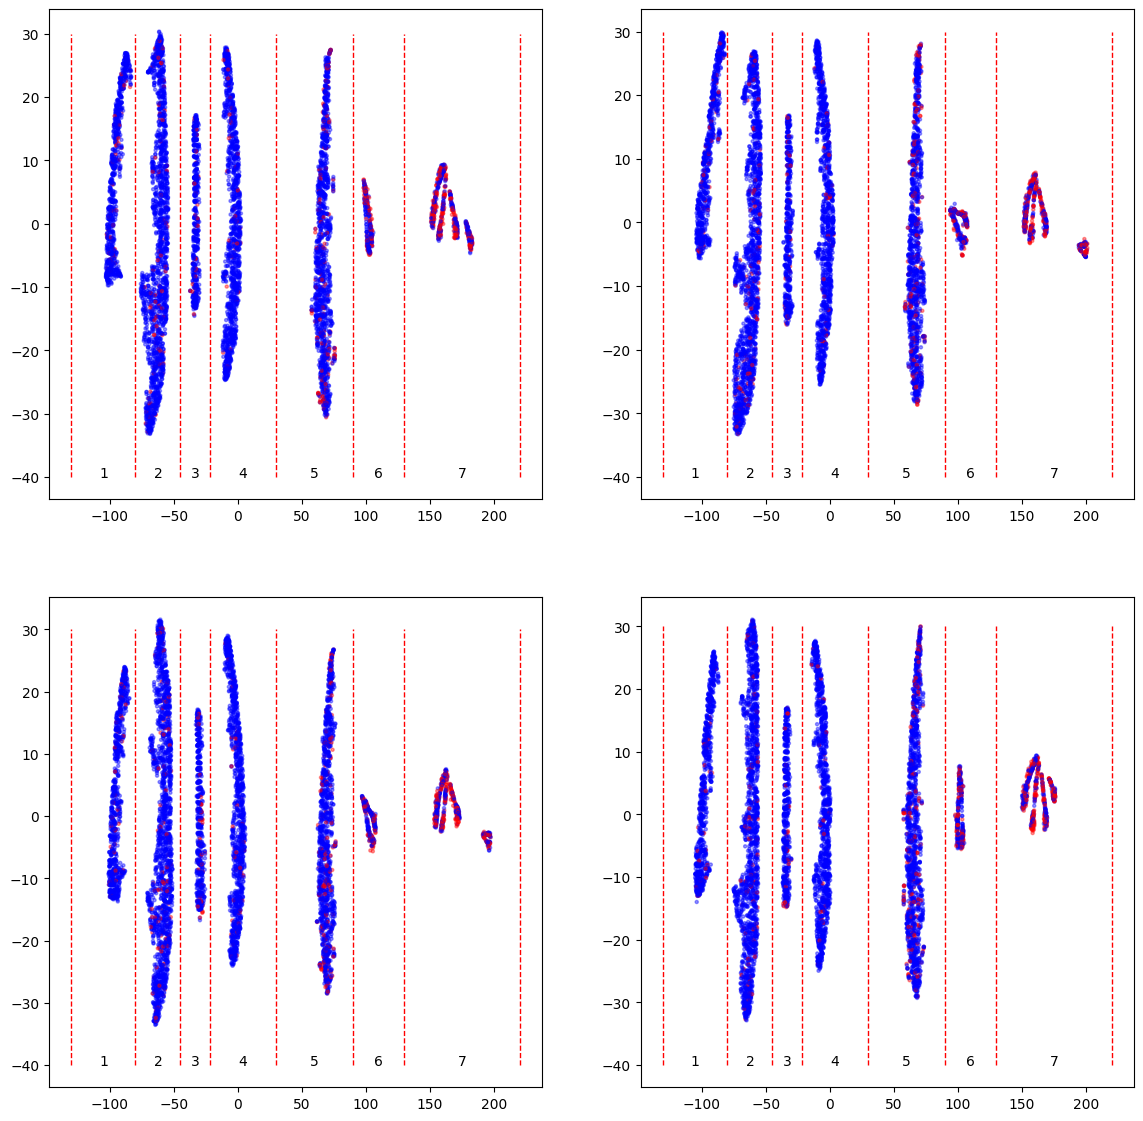

In [47]:
y_range = [-40, 30]
delimiters = [
    {'x': [-130, -130], 'y': y_range},
    {'x': [-80, -80], 'y': y_range},
    {'x': [-45, -45], 'y': y_range},
    {'x': [-22, -22], 'y': y_range},
    {'x': [30, 30], 'y': y_range},
    {'x': [90, 90], 'y': y_range},
    {'x': [130, 130], 'y': y_range},
    {'x': [220, 220], 'y': y_range},
]

cluster_proba = {}

fig, axs = plt.subplots(2, 2, figsize=(14, 14))
split_no = 0
for ax, df_tsne in zip(axs.flatten(), dfs_tsne):
    split_no += 1
    ax.scatter(df_tsne['tsne_x'], df_tsne['tsne_y'], c=y_b_train.iloc[df_tsne.index], s=5, cmap='bwr', alpha=0.4)
    for i, delim_coord in enumerate(delimiters):
        ax.plot(delim_coord['x'], delim_coord['y'], 'r--', lw=1)
        if i > 0:
            cluster_proba[i] = {}
            x_min, x_max = delimiters[i-1]['x'][0], delimiters[i]['x'][0]
            ax.annotate(str(i), xy=(int(np.mean([x_min, x_max])), y_range[0]), ha='center')
            cluster_idxs = df_tsne[(df_tsne['tsne_x'] > x_min) & (df_tsne['tsne_x'] < x_max)].index
            cluster_proba[i]['idxs'] = cluster_idxs
            cluster_proba[i]['proba'] = df.iloc[cluster_idxs]['y'].mean()
print('Cluster \tObserv \tProba')
for key, item in cluster_proba.items():
    print('Cluster {} \t{} \t{:.2f}'.format(key, len(cluster_proba[key]['idxs']), cluster_proba[key]['proba']*100))

### Testing KNN classification

In [48]:
df_knn_train = pd.read_csv('datasets/processed/bank-train-encoded-opt4.csv', comment='#')
df_knn_test = pd.read_csv('datasets/processed/bank-test-encoded-opt4.csv', comment='#')
y_knn_train = df_knn_train['y']
X_knn_train = df_knn_train.drop(columns=['y'])
y_knn_test = df_knn_test['y']
X_knn_test = df_knn_test.drop(columns=['y'])

#### Simple KNN classifier

In [49]:
knn_clf = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
knn_clf.fit(X_knn_train, y_knn_train)

KNeighborsClassifier(n_neighbors=3)

Scores:
Indicator  	Train 	Test
accuracy:     	0.9235 	0.8839
precision:     	0.7554 	0.4750
recall:     	0.4744 	0.2931
f1:     	0.5828 	0.3625
auc:     	0.7275 	0.6260


{'accuracy': {'train': 0.9234851375255801, 'test': 0.8838714898438133},
 'precision': {'train': 0.7553921568627451, 'test': 0.47497089639115253},
 'recall': {'train': 0.4744458128078818, 'test': 0.29310344827586204},
 'f1': {'train': 0.5828290468986385, 'test': 0.36250555308751664},
 'auc': {'train': 0.7274703363378813, 'test': 0.6259862886614148}}

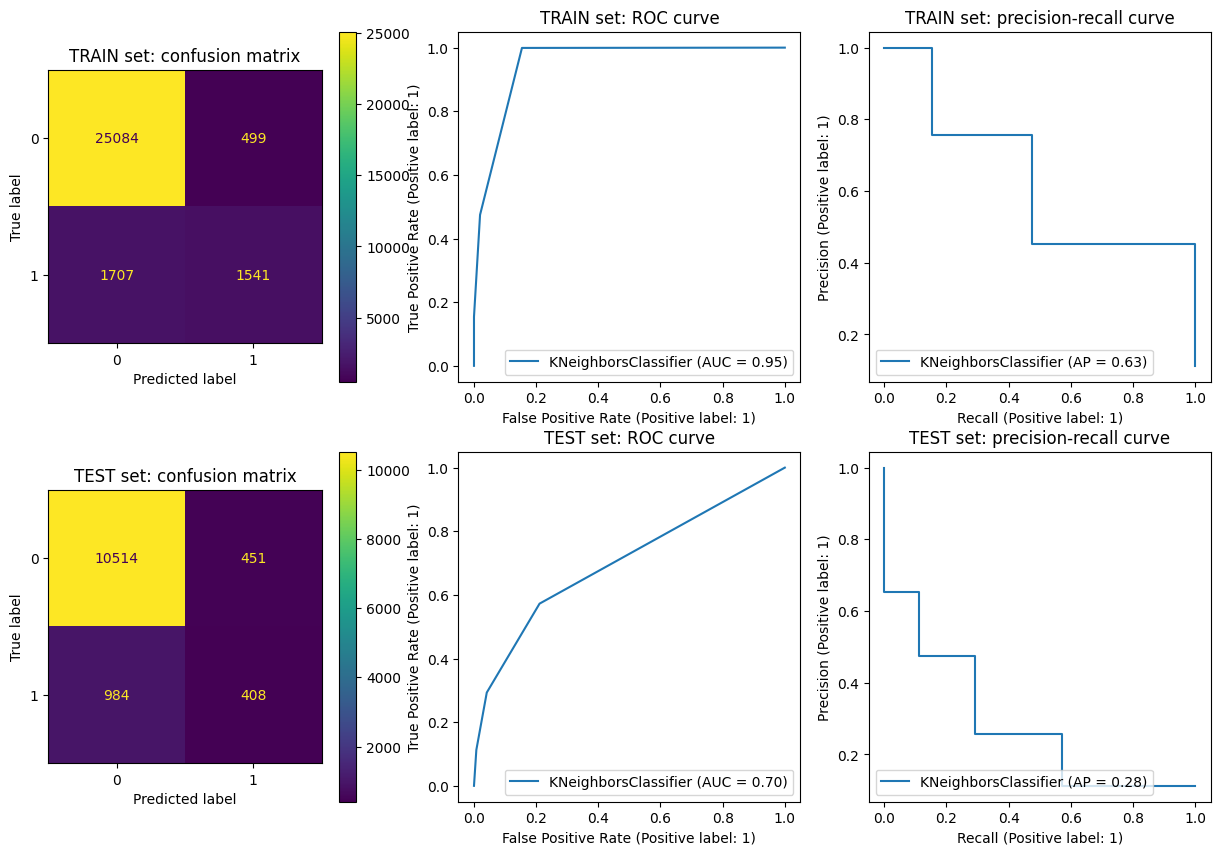

In [50]:
get_model_results(knn_clf, train_set=(X_knn_train, y_knn_train), test_set=(X_knn_test, y_knn_test), show_charts=True)

#### Tuned KNN classifier

In [51]:
param_grid = [
    {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'brute'], 'p': [1, 2, 3]},
    {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'], 'leaf_size': [20, 30, 40], 'p': [1, 2, 3]}
]

In [52]:
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto',),
    param_grid=param_grid,
    scoring='recall',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=56757654),
    return_train_score=True,
    n_jobs=3
)
knn_grid.fit(X_knn_train, y_knn_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=56757654, shuffle=True),
             estimator=KNeighborsClassifier(n_neighbors=3), n_jobs=3,
             param_grid=[{'algorithm': ['auto', 'brute'],
                          'n_neighbors': [1, 2, 3, 4, 5],
                          'weights': ['uniform', 'distance']},
                         {'algorithm': ['ball_tree', 'kd_tree'],
                          'leaf_size': [20, 30, 40],
                          'n_neighbors': [1, 2, 3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='recall')

Scores:
Indicator  	Train 	Test
accuracy:     	0.9953 	0.8505
precision:     	0.9805 	0.3394
recall:     	0.9778 	0.3455
f1:     	0.9792 	0.3425
auc:     	0.9877 	0.6301


{'accuracy': {'train': 0.9953175401477576, 'test': 0.850530063931375},
 'precision': {'train': 0.9805495523309663, 'test': 0.3394495412844037},
 'recall': {'train': 0.9778325123152709, 'test': 0.34554597701149425},
 'f1': {'train': 0.9791891475258209, 'test': 0.3424706301174795},
 'auc': {'train': 0.9876849697565098, 'test': 0.6300917299558156}}

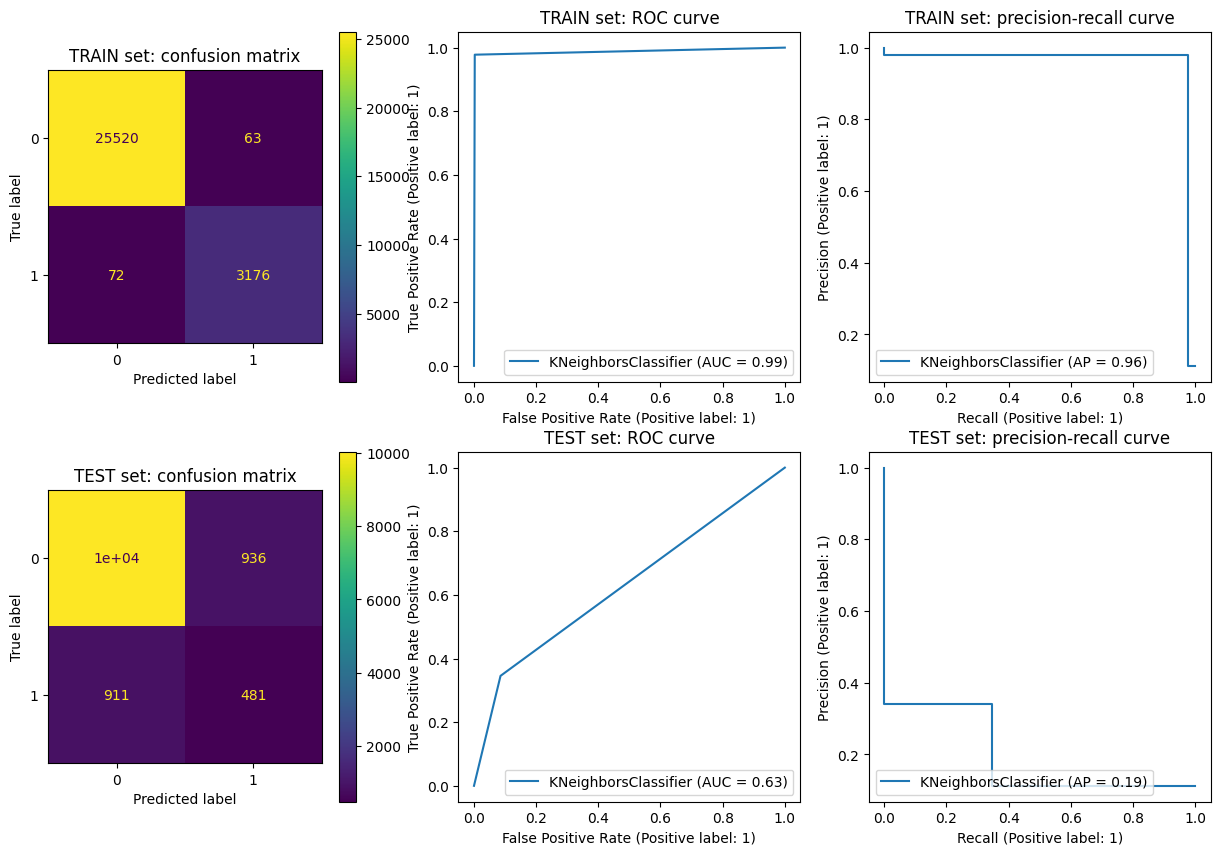

In [53]:
get_model_results(knn_grid.best_estimator_, train_set=(X_knn_train, y_knn_train), test_set=(X_knn_test, y_knn_test), show_charts=True)

In [54]:
knn_grid.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [55]:
cv_res = knn_grid.cv_results_